**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

**Kaggle Team Name:** \_\_\_\_\_

# CS5489 - Assignment 2 - Game Music Tagging
Due date: see Assignment 2 on Canvas

## Goal
In this assignment, the task is to annotate or tag a music clip with descriptive (semantic) keywords.  This kind of content-based tagging system could be useful to musicians and sound engineers who want to automatically organize their sound library, or search for sound or music by keyword.

## Dataset of 80s Game Music

This dataset contains video game music from an 80s-era programmable sound generator based on FM (frequency modulation). The music was for Sega and MSX PC games. Each song is annotated with emotion tags. _The data is publicly available - please do not search for it and cheat._


## Methodology
Semantic annotation is a multi-label classification problem, where each label corresponds to one sound tag and is a binary classification problem. The labels can co-occur (multiple labels can be assigned to the same sound), which makes it different from multi-class classification (where only one label can be assigned).  Sound is a temporal process, so the important thing is how to define the _feature space_ for representing the sound, before learning the binary classifiers. You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space for sound annotation.  You are free to use methods that were not introduced in class, as long as you present the details in the report.  You can also consider the co-occurence of the labels to help with the multi-label classification.


## Evaluation of Tagging

For evaluation, you will predict the presence/absence of tags for each test sound. The evaluation metric is "Mean column-wise AUC".  AUC is the area under the ROC curve, which plots FPR vs TPR.  "Mean column-wise" computes the average of the AUCs for the tags.  To compute AUC, you will need to predict the score of each label (e.g., decision function value, probability, etc.) rather than the label.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas. You must submit your Kaggle account name to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline. This is to prevent students from creating multiple Kaggle accounts to gain unfair advantage.

**Note:** You can only submit 2 times per day to Kaggle!


## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment2.ipynb` with your source code and documentation.  _**You should write about all the various attempts that you make to find a good solution.**_ You may also submit python scripts as source code, but your documentation must be in the ipynb file.
2. Your final csv submission file to Kaggle.
3. The ipynb file `Assignment2-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**
4. Your Kaggle username (submitted to the "Kaggle Username" assignment on Canvas 1 week before the Assignment 2 deadline)

Files should be uploaded to Assignment 2 on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 45% - Results using various feature representations, dimensionality reduction methods, classification methods, etc.
- 30% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 5% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

**Note: This is an individual assignment. Every student must turn in their own work!**
<hr>

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path

d:\anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\anaconda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def showAudio(info):
    myfile = 'musicmp3/' + info['fname'] + '.mp3'
    if os.path.exists(myfile):
        display(Audio(myfile))
    else:
        print("*** mp3 file " + myfile + " could not be found ***")

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files. Here we assume the data is stored in the `musicdata` directory. The below code will load the data, including tags and extracted features.

In [3]:
train_tags  = load_pickle('musicdata/train_tags.pickle3')
train_mfccs = load_pickle('musicdata/train_mfccs.pickle3')
train_mels  = load_pickle('musicdata/train_mels.pickle3')
train_info  = load_pickle('musicdata/train_info.pickle3')

test_mfccs = load_pickle('musicdata/test_mfccs.pickle3')
test_mels  = load_pickle('musicdata/test_mels.pickle3')
test_info  = load_pickle('musicdata/test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set.
- `train_mels` - the Mel-frequency spectrogram for each sound in the training set. Mel-frequency is a logarithmically-transformed frequency with better perceptual distance.  More details [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8).
- `train_mfccs` -  MFCCs (Mel-frequency cepstrum coefficients) are dimensionality-reduced version of the Mel-frequency spectrogram. Specifically, the log is applied to the magnitudes, and then a Discrete Cosine Transform is applied at each time. 
- `train_tags` - the descriptive tags for each sound in the training set.
- `test_info` - info about each sound in the test set.
- `test_mels` - the Mel Spectrogram for each sound in the test.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the one song in the training set, as well as the tags and other info. To play the audio, we assume the mp3s are available in the `musicmp3` directory.

In [4]:
ii = 14
showAudio(train_info[ii])
print(train_tags[ii])
print(train_info[ii])

['fluttered', 'calm']
{'id': 'eb7jboiu', 'tags': ['fluttered', 'calm'], 'top_tag': 'fluttered', 'fname': 'eb7jboiu'}


Here is the Mel-frequency spectrogram, which shows the frequency content over time. The spectrogram is stored in an `B x T` matrix, where `B` is the number of bins, and `T` is the temporal length.  The left plot shows the original Mel spectrogram (with time increasing to the right).  The right plot shows the log magnitude, which can better visualize the differences.  Here we use `B=128` Mel-bins.

(143, 128)


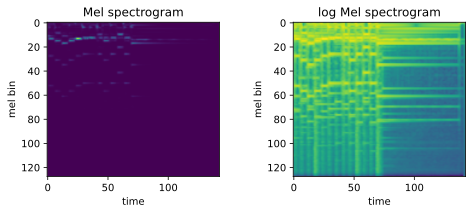

In [5]:
print(train_mels[ii].shape)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.imshow(train_mels[ii].T);
plt.xlabel('time')
plt.ylabel('mel bin');
plt.title('Mel spectrogram')
plt.subplot(1,2,2)
plt.imshow(log(train_mels[ii].T));
plt.xlabel('time')
plt.ylabel('mel bin');
plt.title('log Mel spectrogram')
plt.tight_layout()

MFCCs are a dimensionality-reduced version of the Mel-spectrogram.  To get the MFCC, the Discrete Cosine Transform (DCT) is applied to each 128-dim log-Mel bin vector.  Here we use 20-dimension DCT, so the 128-dim vector is convereted to 20-dim in each time step.  The left plot shows the MFCCs as an image, while the right plots the individual dimensions over time.

(143, 20)


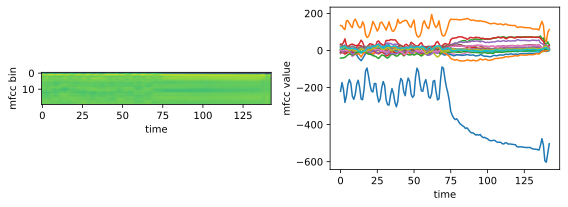

In [6]:
print(train_mfccs[ii].shape)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(train_mfccs[ii].T)
plt.xlabel('time')
plt.ylabel('mfcc bin')
plt.subplot(1,2,2)
plt.plot(train_mfccs[ii]);
plt.xlabel('time')
plt.ylabel('mfcc value');
plt.tight_layout()

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [7]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [8]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [9]:
print(train_dmfccs[0][0])

[-184.3729      88.103615   -13.998435    29.957767   -14.865648
    4.795857    -4.8739123   18.453674     2.810142    11.200221
  -14.67706      3.9444768   -7.754983     3.0393426   -8.849848
   11.00738      2.698762     8.2848625   -4.388589     3.5377586
   97.0066       5.5644913    7.4739122    1.4915733    1.4182262
    3.055902     3.9508502    0.6885147   -6.1345553   -5.370047
   -0.3312292    3.769481     2.8691254    2.739856     0.721117
    1.0148563   -1.7685852   -2.1253805   -4.6949587    2.6014802]


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [10]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(1742938, 40)


In [11]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-2.2776012e+02,  1.6792923e+02,  5.3576932e+00, ...,
         3.6026591e-01,  3.3634311e-01, -2.2023678e-01],
       [-1.7031969e+02,  9.9945198e+01,  1.4115372e+01, ...,
         7.4326703e-03,  2.4297355e-01,  1.0558966e+00],
       [-4.3284125e+02,  5.7973404e+00, -9.6525822e+00, ...,
        -1.0773135e-02,  6.8042761e-01,  8.2857162e-02],
       ...,
       [-1.5053831e+02,  6.3272598e+01,  1.5092020e+01, ...,
         5.0454837e-01,  1.1879567e+00,  8.6447018e-01],
       [-1.5146947e+02,  5.7821571e+01,  7.6386547e+00, ...,
        -1.5683411e-01,  7.0671612e-01, -9.3387671e-02],
       [-1.7020773e+02,  9.1661728e+01,  3.6319508e+01, ...,
        -8.6277032e-01, -4.0861821e-01, -6.4709365e-02]], dtype=float32)

Now transform the data into BOW.

In [12]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [13]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

# Tag pre-processing

Next, we extract all the tags from the data, and get a unique list of tags.

In [14]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

bizarre: 48
boring: 10
calm: 63
cheerful: 223
cold: 54
comic: 26
creepy: 74
cute: 38
depressed: 57
dreamy: 59
fluttered: 115
frustrating: 13
grand: 62
peaceful: 75
rhythmic: 150
serious: 166
speedy: 180
tense: 249
touching: 41


Now we convert the list of tags for each sound into binary attributes.

In [15]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [16]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)

In [17]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)

array([ 48.,  10.,  63., 223.,  54.,  26.,  74.,  38.,  57.,  59., 115.,
        13.,  62.,  75., 150., 166., 180., 249.,  41.])

## Baseline experiments

Next, we will run a baseline experiment doing semantic tagging with bag-of-audio words.

Apply TF-IDF to the count vectors.

In [18]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

Now learn a logisic regression classifier for each tag.

In [19]:
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - bizarre
training 1 - boring
training 2 - calm
training 3 - cheerful
training 4 - cold
training 5 - comic
training 6 - creepy
training 7 - cute
training 8 - depressed
training 9 - dreamy
training 10 - fluttered
training 11 - frustrating
training 12 - grand
training 13 - peaceful
training 14 - rhythmic
training 15 - serious
training 16 - speedy
training 17 - tense
training 18 - touching


To see how we did on tagging the training set, we compute the tag scores.

In [20]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


And then plot the ROC curve using the training classes and training predicted scores.

In [21]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.grid(True)

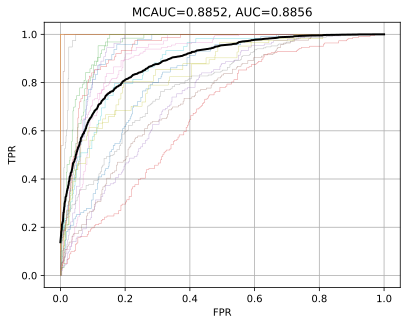

In [22]:
plot_roc(tagnames, train_classes, train_predscore)

Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

Now apply the LR classifiers to the test set to predict the score for each tag.

In [23]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


We have the scores, now lets look at the predicted tags.

In [24]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

We need to convert the score into a binary class label using a threshold (usually 0).

In [25]:
# convert score into binary class 0 or 1.  
test_predclass = test_predscore>0

# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

Here is an example of the predicted labels and the label scores.

bizarre cheerful creepy rhythmic speedy tense


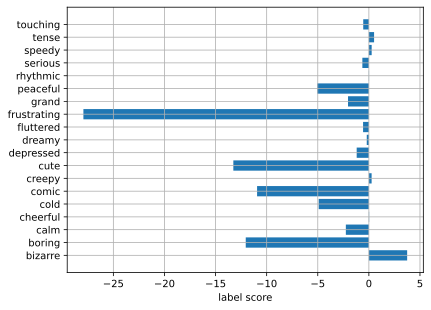

In [26]:
ii = 0
# view tags and audio
print(test_predtags[ii])
showAudio(test_info[ii])

# view the scores
plt.barh(tagnames, test_predscore[ii]);
plt.xlabel('label score')
plt.grid(True)

Now write the tag scores for the test set for submission to Kaggle. We need to upload the tag scores so that Kaggle can generate the ROC curves and calculate AUC.

In [27]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [28]:
#write_csv_kaggle_tags("music_bow_baseline.csv", tagnames, test_predscore)

## YOUR CODE and DOCUMENTATION HERE

In [29]:
#1
from sklearn.svm import SVC
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = SVC()
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - bizarre
training 1 - boring
training 2 - calm
training 3 - cheerful
training 4 - cold
training 5 - comic
training 6 - creepy
training 7 - cute
training 8 - depressed
training 9 - dreamy
training 10 - fluttered
training 11 - frustrating
training 12 - grand
training 13 - peaceful
training 14 - rhythmic
training 15 - serious
training 16 - speedy
training 17 - tense
training 18 - touching


In [ ]:
#2
from sklearn.ensemble import GradientBoostingClassifier
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr =GradientBoostingClassifier()
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

In [ ]:
#3
from sklearn.ensemble import  AdaBoostClassifier
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr =AdaBoostClassifier()
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

In [30]:
#4
from sklearn.ensemble import GradientBoostingClassifier
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr =GradientBoostingClassifier(n_estimators=200)
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - bizarre
training 1 - boring
training 2 - calm
training 3 - cheerful
training 4 - cold
training 5 - comic
training 6 - creepy
training 7 - cute
training 8 - depressed
training 9 - dreamy
training 10 - fluttered
training 11 - frustrating
training 12 - grand
training 13 - peaceful
training 14 - rhythmic
training 15 - serious
training 16 - speedy
training 17 - tense
training 18 - touching


In [32]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


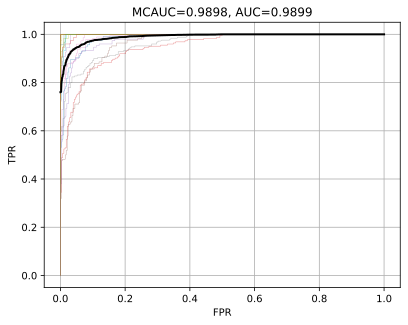

In [33]:
plot_roc(tagnames, train_classes, train_predscore)

In [34]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - bizarre
predicting 1 - boring
predicting 2 - calm
predicting 3 - cheerful
predicting 4 - cold
predicting 5 - comic
predicting 6 - creepy
predicting 7 - cute
predicting 8 - depressed
predicting 9 - dreamy
predicting 10 - fluttered
predicting 11 - frustrating
predicting 12 - grand
predicting 13 - peaceful
predicting 14 - rhythmic
predicting 15 - serious
predicting 16 - speedy
predicting 17 - tense
predicting 18 - touching


In [35]:
test_predclass = test_predscore>0

# convert to tags
test_predtags = class2tags(test_predclass, tagnames)

grand peaceful


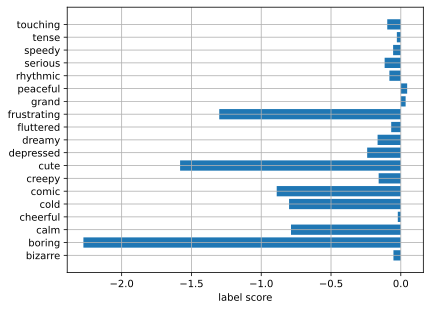

In [36]:
ii = 0
# view tags and audio
print(test_predtags[ii])
showAudio(test_info[ii])

# view the scores
plt.barh(tagnames, test_predscore[ii]);
plt.xlabel('label score')
plt.grid(True)

In [37]:
write_csv_kaggle_tags("music_bow_baseline.csv", tagnames, test_predscore)